# Here is what you need to know about staying in Boston

Questions:
* What high-rent times of the year should you avoid? __Check__
* Which are the hippest neighborhoods?
* Do some neighborhoods have particularly high ratings?
* Location, location, location - how important is location in determining the price of a flat?


## CRISP-DM Process

2019 data from dataset on website from 14 September, 2018

2018 data from dataset on website from 06 October, 2017

2017 data from dataset on website from 07 September, 2016

In [152]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from datetime import datetime
import re
from collections import Counter, defaultdict
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline


In [2]:
calendar2017 = pd.read_csv('calendar2017.csv', delimiter=',')
calendar2018 = pd.read_csv('calendar2018.csv', delimiter=',')
calendar2019 = pd.read_csv('calendar2019.csv', delimiter=',')

listings = pd.read_csv('listings2017.csv', delimiter=',')
reviews = pd.read_csv('reviews2017.csv', delimiter=',')


In [3]:
print(calendar2017.shape)
print(listings.shape)
print(reviews.shape)


(1308890, 4)
(3585, 95)
(68275, 6)


In [4]:
# check out the missing values from 
print(np.sum(calendar2017.isnull()))

print('Portion of missing values in price column: {}'.format(calendar2017["price"].isnull().sum()/calendar2017.shape[0]))


listing_id         0
date               0
available          0
price         665853
dtype: int64
Portion of missing values in price column: 0.5087157820748879


In [5]:
calendar2017.head()

listing_id        date available price
0    12147973  2017-09-05         f   NaN
1    12147973  2017-09-04         f   NaN
2    12147973  2017-09-03         f   NaN
3    12147973  2017-09-02         f   NaN
4    12147973  2017-09-01         f   NaN

In [6]:
listings.head()

id                            listing_url       scrape_id  \
0  12147973  https://www.airbnb.com/rooms/12147973  20160906204935   
1   3075044   https://www.airbnb.com/rooms/3075044  20160906204935   
2      6976      https://www.airbnb.com/rooms/6976  20160906204935   
3   1436513   https://www.airbnb.com/rooms/1436513  20160906204935   
4   7651065   https://www.airbnb.com/rooms/7651065  20160906204935   

  last_scraped                                           name  \
0   2016-09-07                     Sunny Bungalow in the City   
1   2016-09-07              Charming room in pet friendly apt   
2   2016-09-07               Mexican Folk Art Haven in Boston   
3   2016-09-07  Spacious Sunny Bedroom Suite in Historic Home   
4   2016-09-07                            Come Home to Boston   

                                             summary  \
0  Cozy, sunny, family home.  Master bedroom high...   
1  Charming and quiet room in a second floor 1910...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Come experience the comforts of home away from...   
4  My comfy, clean and relaxing home is one block...   

                                               space  \
0  The house has an open and cozy feel at the sam...   
1  Small but cozy and quite room with a full size...   
2  Come stay with a friendly, middle-aged guy in ...   
3  Most places you find in Boston are small howev...   
4  Clean, attractive, private room, one block fro...   

                                         description experiences_offered  \
0  Cozy, sunny, family home.  Master bedroom high...                none   
1  Charming and quiet room in a second floor 1910...                none   
2  Come stay with a friendly, middle-aged guy in ...                none   
3  Come experience the comforts of home away from...                none   
4  My comfy, clean and relaxing home is one block...                none   

                               neighborhood_overview        ...          \
0  Roslindale is quiet, convenient and friendly. ...        ...           
1  The room is in Roslindale, a diverse and prima...        ...           
2  The LOCATION: Roslindale is a safe and diverse...        ...           
3  Roslindale is a lovely little neighborhood loc...        ...           
4  I love the proximity to downtown, the neighbor...        ...           

  review_scores_value requires_license license jurisdiction_names  \
0                 NaN                f     NaN                NaN   
1                 9.0                f     NaN                NaN   
2                10.0                f     NaN                NaN   
3                10.0                f     NaN                NaN   
4                10.0                f     NaN                NaN   

  instant_bookable cancellation_policy require_guest_profile_picture  \
0                f            moderate                             f   
1                t            moderate                             f   
2                f            moderate                             t   
3                f            moderate                             f   
4                f            flexible                             f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              1   
1                                f                              1   
2                                f                              1   
3                                f                              1   
4                                f                              1   

   reviews_per_month  
0                NaN  
1               1.30  
2               0.47  
3               1.00  
4               2.25  

[5 rows x 95 columns]

In [7]:
# clean the price column to allow for arithmetic operations
conv_str = lambda x: str(x)[1:].replace(',', '') if '$' in str(x) else x

calendar2017['price'] = calendar2017['price'].apply(conv_str)
calendar2017['price'] = calendar2017['price'].apply(lambda x: float(x))
calendar2017.head()


listing_id        date available  price
0    12147973  2017-09-05         f    NaN
1    12147973  2017-09-04         f    NaN
2    12147973  2017-09-03         f    NaN
3    12147973  2017-09-02         f    NaN
4    12147973  2017-09-01         f    NaN

In [8]:
# get the descriptive statistics of average price per listing
grouped_price = calendar2017.groupby('listing_id')['price'].mean()

grouped_price.describe()


count    2906.000000
mean      196.935127
std       157.729807
min        11.000000
25%        90.000000
50%       160.000000
75%       264.717664
max      4000.000000
Name: price, dtype: float64

C:\Users\julia\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\julia\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


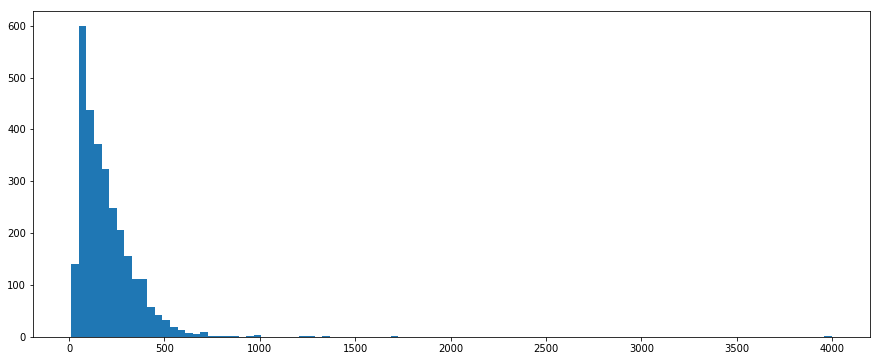

In [9]:
# plot the average prices across all listing ids
plt.figure(figsize=(15,6))
plt.hist(grouped_price, bins=100);


In [10]:
# average price throughout time
grouped_date = calendar2017.groupby('date')['price'].mean()

grouped_date.describe()


count    365.000000
mean     201.165200
std       20.989130
min      177.023002
25%      186.764936
50%      196.100469
75%      205.207474
max      286.921977
Name: price, dtype: float64

In [11]:
grouped_date

date
2016-09-06    241.043860
2016-09-07    251.833691
2016-09-08    251.748749
2016-09-09    261.859327
2016-09-10    266.847280
2016-09-11    249.565041
2016-09-12    245.732597
2016-09-13    250.206977
2016-09-14    256.647799
2016-09-15    269.092903
2016-09-16    286.921977
2016-09-17    286.185554
2016-09-18    261.592955
2016-09-19    246.632945
2016-09-20    241.203993
2016-09-21    244.225750
2016-09-22    249.625355
2016-09-23    250.712274
2016-09-24    259.378705
2016-09-25    256.321691
2016-09-26    244.979556
2016-09-27    245.324846
2016-09-28    234.278376
2016-09-29    243.275229
2016-09-30    246.097490
2016-10-01    245.459259
2016-10-02    236.312305
2016-10-03    230.048227
2016-10-04    228.680249
2016-10-05    229.066098
                 ...    
2017-08-07    200.423529
2017-08-08    200.494684
2017-08-09    201.649692
2017-08-10    201.793509
2017-08-11    208.539665
2017-08-12    204.606484
2017-08-13    199.385818
2017-08-14    196.306145
2017-08-15    197.55

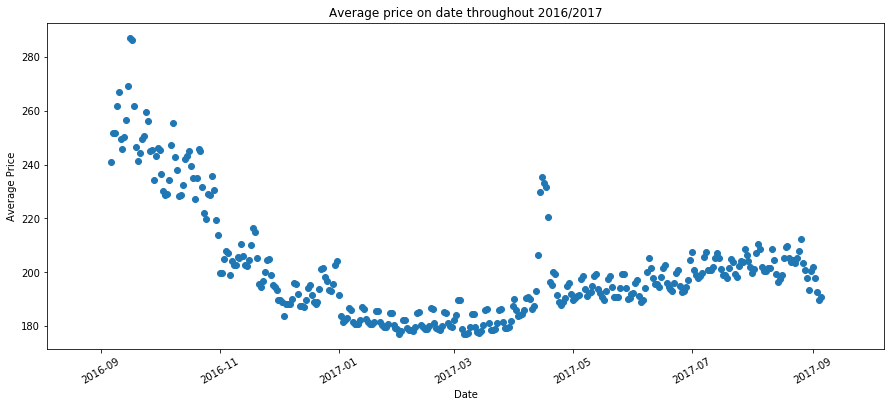

In [12]:
# plot the average prices across all dates
index_date = [np.datetime64(x) for x in grouped_date.index]

fig, ax = plt.subplots(figsize=(15,6))

plt.scatter(index_date, grouped_date.values)
plt.xlabel('Date')
plt.ylabel('Average Price')
#ax.set_ylim([100,500])
plt.title('Average price on date throughout 2016/2017')
plt.xticks(rotation=30);


In [13]:
# cleaning function
def clean(df, to_be_cleaned, string_remov):
    '''
    cleaning a column in a dataframe of a specified string
    INPUT: df = dataframe, to_be_cleaned = name of column that needs to be cleaned, string_remov = string in column that should be replaced
    OUTPUT: changed dataframe
    '''
    # cleaning price column
    conv_str = lambda x: str(x)[1:].replace(',', '') if string_remov in str(x) else x
    df[to_be_cleaned] = df[to_be_cleaned].apply(conv_str)
    df[to_be_cleaned] = df[to_be_cleaned].apply(lambda x: float(x))
    
    return df


In [14]:
def format_plot(df):
    '''
    formatting a column in a dataframe for a plot function
    INPUT: dataframe
    OUTPUT: Series with average price throughout time; Series with dates in np.datetime64 format
    '''
    # average price throughout time
    grouped_date = df.groupby('date')['price'].mean()
    
    # remove year from date column to allow to lay each calendar dataframe price column on top of each other
    index_date = [x[5:] for x in grouped_date.index]

    return index_date, grouped_date
    

In [15]:
# plotting the price data of relevant calendar dataframes
def plot_cal(x_lst, y_lst, year_lst, color_lst):
    '''
    This function returns a scatterplot with average price data from multiple years layed ontop of each other
    INPUT: index_date is x_lst, grouped_date is y_lst
    OUTPUT: scatterplot of all average prices of calendar dataframes over time
    '''
    # plot data
    fig, ax = plt.subplots(figsize=(15,6))
    
    for i in range(len(x_lst)):
        ax.scatter(x_lst[i], y_lst[i].values, c=color_lst[i], label=year_lst[i])
    
    plt.xlabel('Date')
    plt.ylabel('Average Price')
    ax.set_ylim([100,500])
    monthyearFmt = mdates.DateFormatter('%B')
    ax.xaxis.set_major_formatter(monthyearFmt)
    plt.legend(loc='upper left')
    plt.title('Average price on dates')
    plt.xticks(rotation=30);


In [16]:
# clean all calendar price columns
X2017, y2017 = format_plot(clean(calendar2017, 'price', '$'))
X2018, y2018 = format_plot(clean(calendar2018, 'price', '$'))
X2019, y2019 = format_plot(clean(calendar2019, 'price', '$'))


In [17]:
# format date column to datetime format, removing the year to later allow for overlapping plotting based on day and month
X2017 = [datetime.strptime(x, '%m-%d') for x in X2017]
X2018 = [datetime.strptime(x, '%m-%d') for x in X2018]
X2019 = [datetime.strptime(x, '%m-%d') for x in X2019]

In [18]:
# creating input lists for plot function
x_lst = [X2017, X2018, X2019]
y_lst = [y2017, y2018, y2019]
year_lst = ['2017', '2018', '2019']
color_lst = ['b', 'r', 'g']


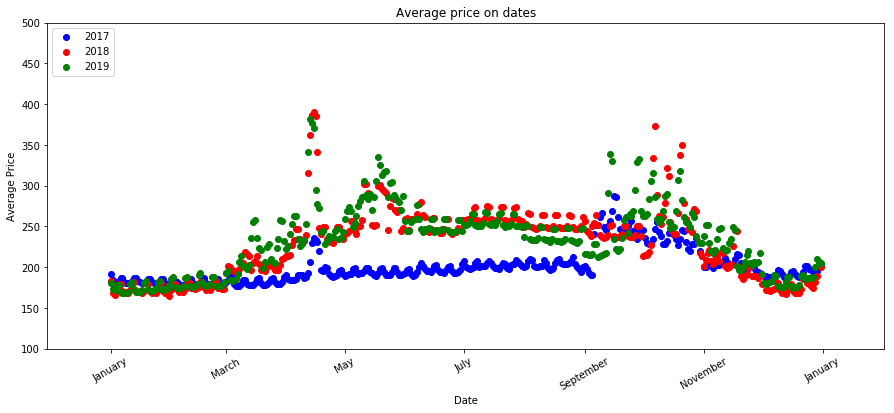

In [19]:
# plotting all three calendars' average prices
plot_cal(x_lst, y_lst, year_lst, color_lst)


In [20]:
# check whether any listings dropped out during the course of the year
grouped_ids = calendar2017.groupby('date')['listing_id'].count()

grouped_ids.describe()


count     365.0
mean     3586.0
std         0.0
min      3586.0
25%      3586.0
50%      3586.0
75%      3586.0
max      3586.0
Name: listing_id, dtype: float64

## Does a higher price indicate that the flat is cleaner?

Let's look at our next question.


In [21]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [43]:
reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [22]:
# get an overview of the review_scores_cleanliness feature
listings['review_scores_cleanliness'].describe()


count    2767.000000
mean        9.258041
std         1.168977
min         2.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: review_scores_cleanliness, dtype: float64

In [23]:
price_per_id = pd.DataFrame(calendar2017.groupby('listing_id')['price'].mean())

price_per_id['listing_id'] = price_per_id.index

price_per_id.index.names = ['id']

new_price = price_per_id.reset_index(drop=True)

new_price

price  listing_id
0      35.204819        3353
1     147.267442        5506
2     197.407407        6695
3      65.000000        6976
4     154.000000        8792
5     225.000000        9273
6     236.856354        9765
7     222.321981        9824
8     266.554945        9855
9     363.394813        9857
10    486.774725        9858
11    269.759207        9860
12    288.776243        9870
13    256.554945        9903
14    150.000000       10730
15    116.395349       10758
16     80.802469       10807
17    110.116279       10809
18    251.744186       10810
19    165.520548       10811
20    200.000000       12356
21    418.354098       12441
22    400.837838       13059
23    451.097403       13589
24    377.994350       13592
25    169.890208       18711
26     75.000000       20000
27    329.000000       21337
28    356.554945       21891
29    233.988796       22208
...          ...         ...
3555   70.700000    14874204
3556  110.710526    14878512
3557  179.000000    14881840
3558   60.000000    14884243
3559  264.562963    14885592
3560   95.644172    14885796
3561   56.839286    14885917
3562  249.000000    14887382
3563  424.011461    14897219
3564  309.000000    14897997
3565  180.255474    14898146
3566   91.383754    14898198
3567   80.000000    14900236
3568  132.769886    14902894
3569  189.405099    14907062
3570  219.206154    14908177
3571  314.971264    14909417
3572  248.397590    14912536
3573  127.074286    14916248
3574  170.000000    14917151
3575  250.000000    14917833
3576  359.000000    14918032
3577  100.000000    14918194
3578  160.000000    14918425
3579   60.854795    14918869
3580  169.515152    14924831
3581   55.000000    14928000
3582  105.380531    14928333
3583   49.000000    14933380
3584  165.113333    14933461

[3585 rows x 2 columns]

In [24]:
cleanliness = pd.DataFrame(listings[['id', 'review_scores_cleanliness']])

cleanliness = cleanliness.rename(index=str, columns={'id': 'listing_id'})

cleanliness

#cleanliness['listing_id']


listing_id  review_scores_cleanliness
0       12147973                        NaN
1        3075044                        9.0
2           6976                        9.0
3        1436513                       10.0
4        7651065                       10.0
5       12386020                       10.0
6        5706985                       10.0
7        2843445                       10.0
8         753446                       10.0
9         849408                        9.0
10      12023024                        8.0
11       1668313                       10.0
12       2684840                       10.0
13      13547301                       10.0
14       5434353                        9.0
15        225979                       10.0
16       3420384                       10.0
17      13512930                       10.0
18       7482195                        NaN
19       7252607                       10.0
20       2583074                       10.0
21      13251243                       10.0
22        225834                       10.0
23       6400432                        9.0
24       5498472                       10.0
25        894539                       10.0
26        879929                        9.0
27       9218312                       10.0
28        321328                        8.0
29       1810172                        9.0
...          ...                        ...
3555    13015653                       10.0
3556    14849141                        NaN
3557    14604429                        NaN
3558    14592644                        NaN
3559    12915510                       10.0
3560    14887382                        NaN
3561    14823430                        NaN
3562    14881840                        NaN
3563    11452297                        NaN
3564    14576706                        NaN
3565    14335003                        8.0
3566    14871445                        NaN
3567    14472678                        NaN
3568    14574800                        8.0
3569    14426586                        NaN
3570     3131519                        9.0
3571    14592547                       10.0
3572    14744740                        NaN
3573    14504583                       10.0
3574    14743129                        8.0
3575     5280827                        7.0
3576    14689681                        NaN
3577    13750763                        NaN
3578    14536322                       10.0
3579    14852179                        NaN
3580     8373729                       10.0
3581    14844274                        NaN
3582    14585486                        NaN
3583    14603878                        8.0
3584    14504422                        NaN

[3585 rows x 2 columns]

In [25]:
clean_price = pd.merge(cleanliness, price_per_id, on='listing_id', how='outer')

In [47]:
np.sum(clean_price.isnull())

listing_id                     0
review_scores_cleanliness    818
price                        679
dtype: int64

In [50]:
clean_price = clean_price.dropna(axis=0, how='any')

In [51]:
np.sum(clean_price.isnull())

listing_id                   0
review_scores_cleanliness    0
price                        0
dtype: int64

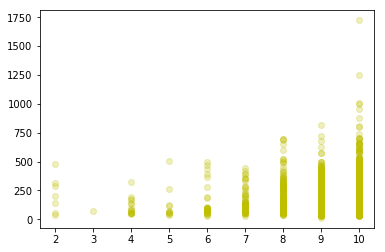

In [52]:
plt.scatter(clean_price['review_scores_cleanliness'], clean_price['price'], c='y', alpha=0.25);

In [55]:
corr, p = pearsonr(clean_price['review_scores_cleanliness'], clean_price['price'])
print(corr)
print(p)


0.11144494613748308
6.196438959803245e-08


## What are the hippest neighborhoods

In [27]:
reviews.head()

listing_id       id        date  reviewer_id reviewer_name  \
0     1178162  4724140  2013-05-21      4298113       Olivier   
1     1178162  4869189  2013-05-29      6452964     Charlotte   
2     1178162  5003196  2013-06-06      6449554     Sebastian   
3     1178162  5150351  2013-06-15      2215611        Marine   
4     1178162  5171140  2013-06-16      6848427        Andrew   

                                            comments  
0  My stay at islam's place was really cool! Good...  
1  Great location for both airport and city - gre...  
2  We really enjoyed our stay at Islams house. Fr...  
3  The room was nice and clean and so were the co...  
4  Great location. Just 5 mins walk from the Airp...

In [28]:
reviews['comments']

0        My stay at islam's place was really cool! Good...
1        Great location for both airport and city - gre...
2        We really enjoyed our stay at Islams house. Fr...
3        The room was nice and clean and so were the co...
4        Great location. Just 5 mins walk from the Airp...
5        A truely exeptional place to stay. The hosts a...
6        It was a really nice time in Boston - best pla...
7        Islam is a very nice guy ! Attentive, funny, h...
8        The place is really well furnished, pleasant a...
9        Our stay at Islam's place was fantastic. We co...
10       Our stay at Islam's was very enjoyable, Islam ...
11       Communication with Islam and his brother was g...
12       Mi estadía en Boston aunque corta fue muy buen...
13       Well sized room for two people with the basic ...
14       GREAT SPACE, PERFECT LOCATION, AWESOME PEOPLE!...
15       The room was exactly as pictured, no frills, y...
16       The room was clean and very comfortable. Havin.

In [29]:
# Add the neighborhood to the reviews dataframe
neighborhoods = pd.DataFrame(listings[['id', 'neighbourhood_cleansed']])

neighborhoods = neighborhoods.rename(index=str, columns={'id': 'listing_id'})

review_ids = pd.DataFrame(reviews[['listing_id', 'comments']])

neighborhood_reviews = pd.merge(review_ids, neighborhoods, on='listing_id', how='outer')

neighborhood_reviews


listing_id                                           comments  \
0         1178162  My stay at islam's place was really cool! Good...   
1         1178162  Great location for both airport and city - gre...   
2         1178162  We really enjoyed our stay at Islams house. Fr...   
3         1178162  The room was nice and clean and so were the co...   
4         1178162  Great location. Just 5 mins walk from the Airp...   
5         1178162  A truely exeptional place to stay. The hosts a...   
6         1178162  It was a really nice time in Boston - best pla...   
7         1178162  Islam is a very nice guy ! Attentive, funny, h...   
8         1178162  The place is really well furnished, pleasant a...   
9         1178162  Our stay at Islam's place was fantastic. We co...   
10        1178162  Our stay at Islam's was very enjoyable, Islam ...   
11        1178162  Communication with Islam and his brother was g...   
12        1178162  Mi estadía en Boston aunque corta fue muy buen...   
13        1178162  Well sized room for two people with the basic ...   
14        1178162  GREAT SPACE, PERFECT LOCATION, AWESOME PEOPLE!...   
15        1178162  The room was exactly as pictured, no frills, y...   
16        1178162  The room was clean and very comfortable. Havin...   
17        1178162  Izzy was great... had clear instructions and n...   
18        1178162  The place was really good, it is like 10 minut...   
19        1178162  The host wasn't there, but it was fine. He lef...   
20        1178162  Izzy was a nice and helpful host with detailed...   
21        1178162  We arrived late from the airport, so the locat...   
22        1178162  Izzy was quick to reply to our request, and pr...   
23        1178162  Everything is exactly as posted! super conveni...   
24        1178162  We didn´t meet Izzy at all!!!! After we arrive...   
25        1178162  I didn't get a chance to meet Izzy but I thoug...   
26        1178162  Izzy's assistant was a nice and helpful person...   
27        1178162  Host wasn't there, but instructions were clear...   
28        1178162  Izzy's place was very convenient for getting t...   
29        1178162  Well we were kind of annoyed to be honest. We ...   
...           ...                                                ...   
69001    14503389                                                NaN   
69002    14610297                                                NaN   
69003     9807292                                                NaN   
69004    14902894                                                NaN   
69005    14866400                                                NaN   
69006    14584547                                                NaN   
69007    14510982                                                NaN   
69008    14848154                                                NaN   
69009    14487346                                                NaN   
69010    14550228                                                NaN   
69011    14773792                                                NaN   
69012    14874204                                                NaN   
69013    14849141                                                NaN   
69014    14604429                                                NaN   
69015    14592644                                                NaN   
69016    14887382                                                NaN   
69017    14823430                                                NaN   
69018    14881840                                                NaN   
69019    11452297                                                NaN   
69020    14576706                                                NaN   
69021    14871445                                                NaN   
69022    14472678                                                NaN   
69023    14426586                                                NaN   
69024    14744740                              

In [30]:
# check missing values
np.sum(neighborhood_reviews.isnull())

# remove missing values 
neighborhood_reviews = neighborhood_reviews.dropna(axis=0, how='any')

# check whether all missing values were removed
np.sum(neighborhood_reviews.isnull())


listing_id                0
comments                  0
neighbourhood_cleansed    0
dtype: int64

I removed all rows that did not have any review comments because dropping the data is the only plausibal thing for string data that I'll be using to analyze word counts.

In [31]:
# group comments by neighborhood
grouped_reviews = pd.DataFrame(neighborhood_reviews.groupby('neighbourhood_cleansed')['comments'].apply(str))

grouped_reviews['neighborhood'] = grouped_reviews.index

grouped_reviews = grouped_reviews.reset_index(drop=True)

grouped_reviews

comments             neighborhood
0   319      Great and awesome!! Everything thing ...                  Allston
1   323      Very clean and well serviced apartmen...                 Back Bay
2   3142     Joseph was a wonderful host. He is th...              Bay Village
3   252      Giulio's roommate Nikolai was friendl...              Beacon Hill
4   622      I had a great time with Lorin and Mel...                 Brighton
5   346      The apartment was very clean, the loc...              Charlestown
6   313      The host canceled this reservation 4 ...                Chinatown
7   215      My wife and I had a great experience ...               Dorchester
8   260      Location is phenomenal.  Host was sup...                 Downtown
9   0        My stay at islam's place was really c...              East Boston
10  255      The host canceled this reservation 13...                   Fenway
11  8594     Staying at Andre's place was a really...                Hyde Park
12  307      It was one of the best my airbnb expe...            Jamaica Plain
13  32180    Rain's condo is amazing and she made ...         Leather District
14  7025     He was very nice.  He showed me all o...    Longwood Medical Area
15  2990     Our hosts were excellent, very friend...                 Mattapan
16  3401      I enjoyed my stay. The host is great...             Mission Hill
17  277      Judith kindly accommodated a late req...                North End
18  983      I enjoyed my stay at Ricardo's. His v...               Roslindale
19  606      What a GREAT Guy!!!\r\n\r\nOne of the...                  Roxbury
20  389      Caroline's place was great, just as t...             South Boston
21  1004     George was a great host and even gave...  South Boston Waterfront
22  268      This apartment is exactly as describe...                South End
23  328      Perfect location! Easy access to the ...                 West End
24  631      Jane is a great host. This house was ...             West Roxbury

In [32]:
# check missing values
grouped_reviews[grouped_reviews['neighborhood'] == 'Back Bay']['comments']

1    323      Very clean and well serviced apartmen...
Name: comments, dtype: object

In [57]:
# function to create wordclouds
def word_cloud(df, column, feature, stop_words):
    '''
    plotting word clouds based on different dataframes, columns, features and words to exclude
    INPUT: df = dataframe, column = the column that the text is grouped by, feature = the text to be plotted, stop_words = all words to be excluded from the wordcloud
    OUTPUT: wordcloud plots
    '''
    count = 0
    
    for item in df[column]:
    
        text_cont = df[df[column] == item][feature][count]
        wordcloud = WordCloud(stopwords=stop_words, random_state=42).generate(text_cont)
        count += 1

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(item)
        plt.show()    
    

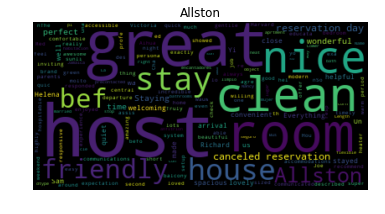

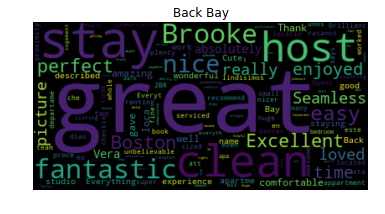

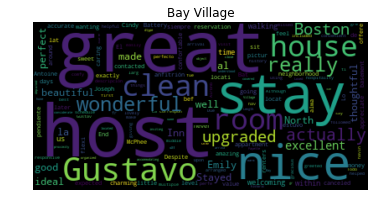

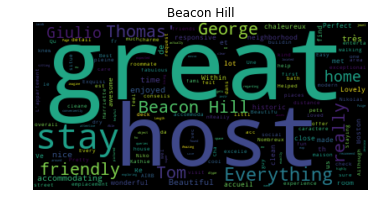

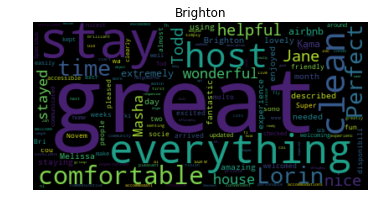

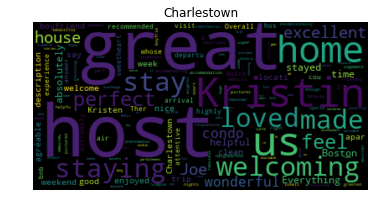

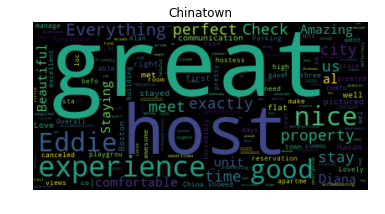

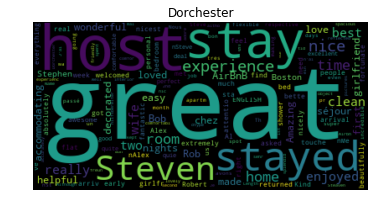

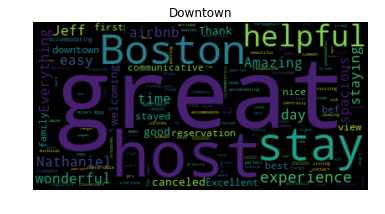

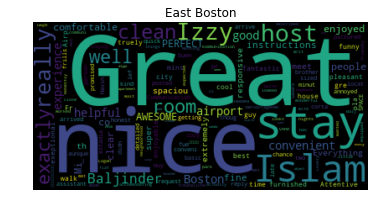

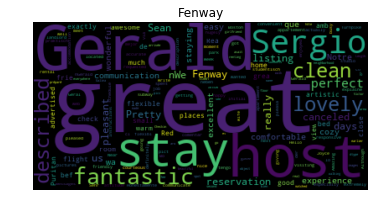

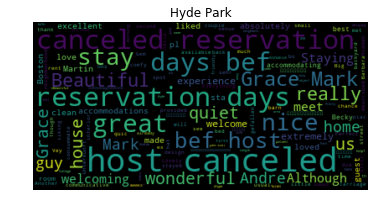

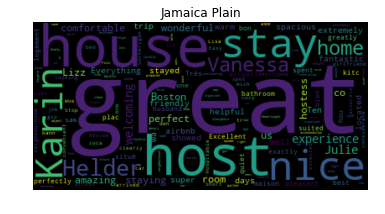

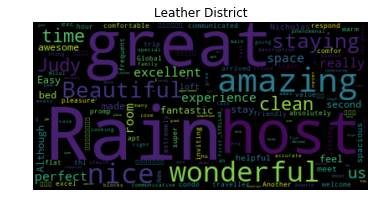

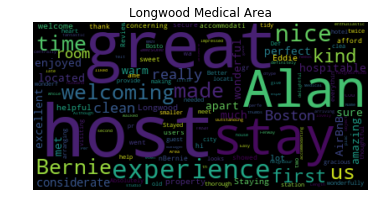

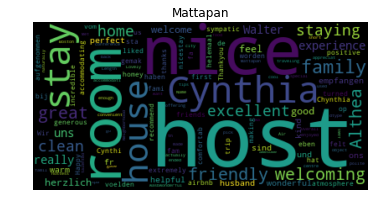

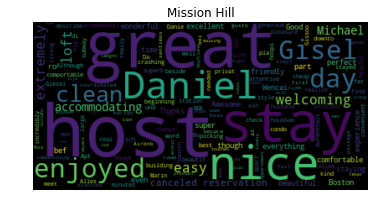

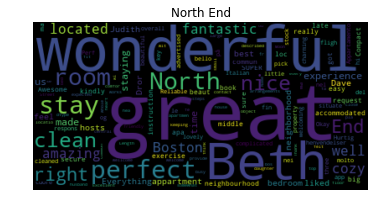

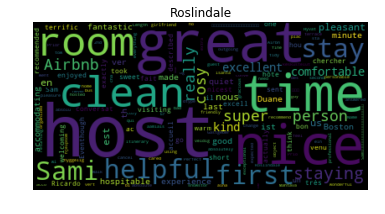

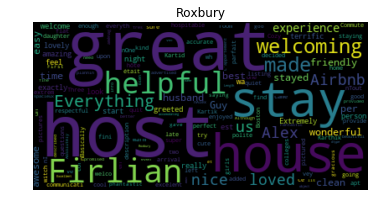

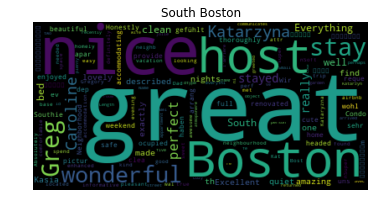

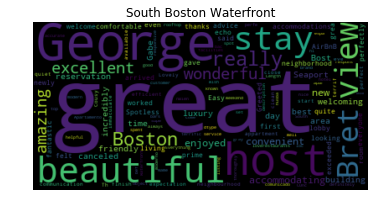

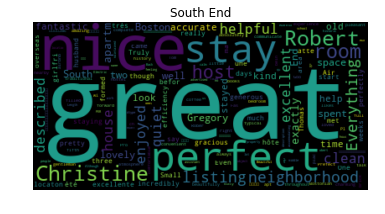

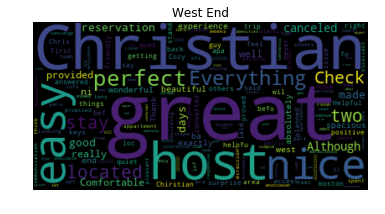

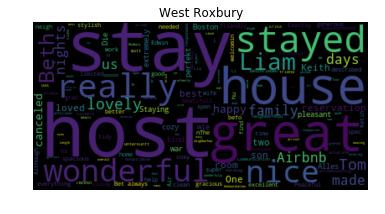

In [59]:
# create a wordcloud for reviews grouped by neighborhoods
add_stop = set(('place', 'apartment', 'location', 'Steven', 'Bob', 'Jeff', 'Kartik', 'Daniel', 'Sami', 'Duane', 'Lisa', 'Bernie', 'Cynthia', 'Gisel', 'Joe', 'Erika', 'Gustavo', 'Thomas', 'Jane', 'Todd', 'Sean', 'Brooke', 'Nicolas', 'Kristin', 'Greg', 'Kama', 'Antoinne', 'Alex', 'Beth', 'Keith'))
stop_words = STOPWORDS.union(add_stop)

word_cloud(grouped_reviews, 'neighborhood', 'comments', stop_words)


## Do some neighborhoods have particularly high ratings?



In [34]:
listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean()

neighbourhood_cleansed
Allston                    90.164835
Back Bay                   91.531646
Bay Village                93.000000
Beacon Hill                93.378698
Brighton                   90.864662
Charlestown                93.697368
Chinatown                  92.121951
Dorchester                 89.280000
Downtown                   92.432203
East Boston                90.272059
Fenway                     89.417112
Hyde Park                  92.280000
Jamaica Plain              94.159322
Leather District           98.333333
Longwood Medical Area      94.000000
Mattapan                   91.000000
Mission Hill               87.695122
North End                  93.725000
Roslindale                 95.380000
Roxbury                    89.803419
South Boston               93.980392
South Boston Waterfront    94.431034
South End                  93.264925
West End                   90.333333
West Roxbury               95.212121
Name: review_scores_rating, dtype: float64

## Which are the hippest neighborhoods

In [92]:
# how many values are missing in neighborhood_overview
np.sum(listings.isnull())['neighborhood_overview']

listings = listings.dropna(axis=0, subset=['neighborhood_overview'], how='any')

np.sum(listings.isnull())['neighborhood_overview']


0

In [93]:
neigh_ov = pd.DataFrame(listings.groupby('neighbourhood_cleansed')['neighborhood_overview'].apply(str))

neigh_ov['neighborhood'] = neigh_ov.index

neigh_ov = neigh_ov.reset_index(drop=True)


In [94]:
# check whether there are missing values in this data frame
np.sum(neigh_ov.isnull())


neighborhood_overview    0
neighborhood             0
dtype: int64

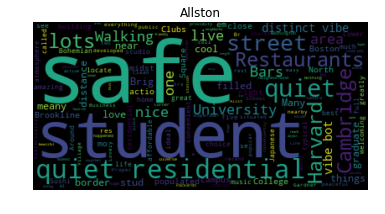

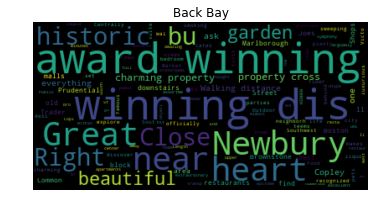

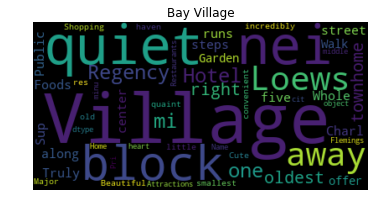

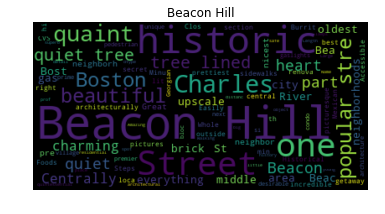

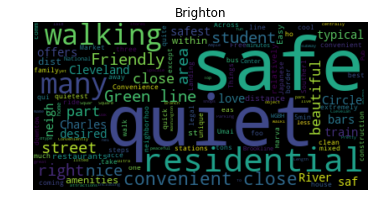

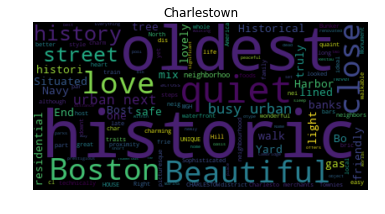

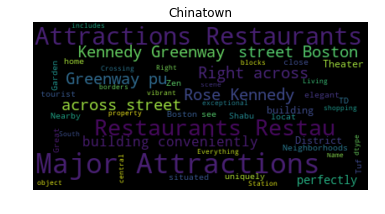

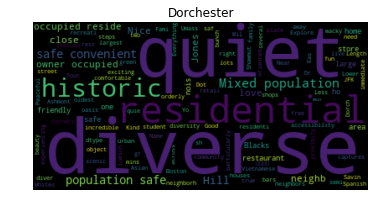

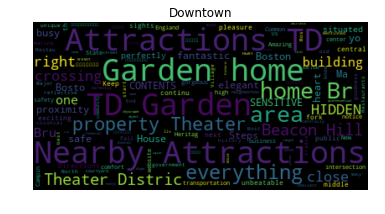

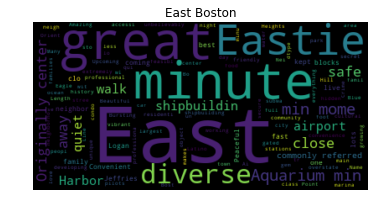

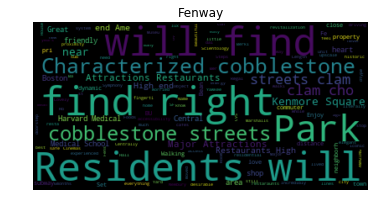

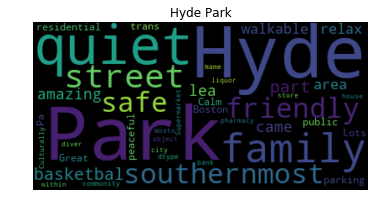

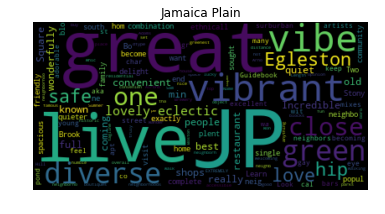

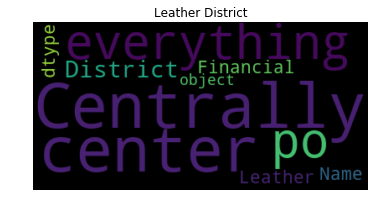

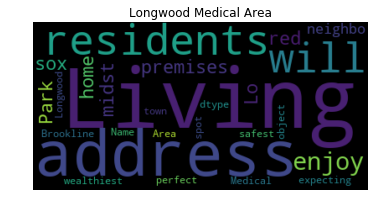

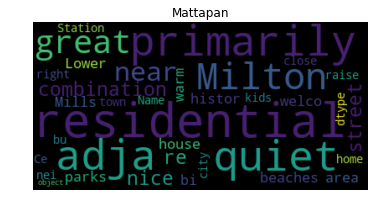

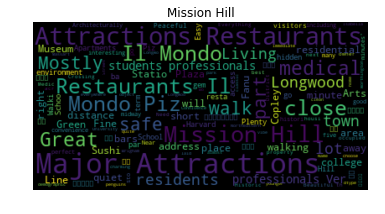

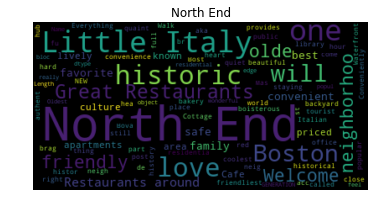

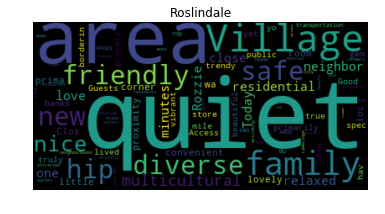

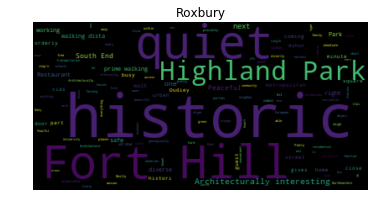

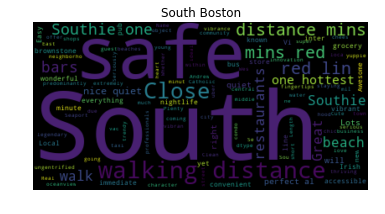

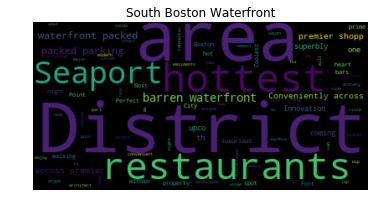

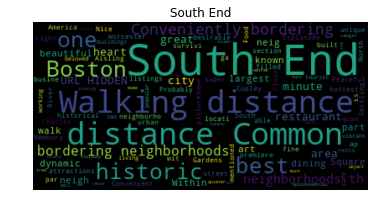

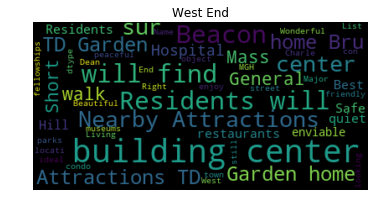

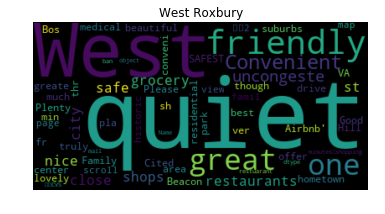

In [143]:
# create word cloud for the neighborhood descriptions
neighborhoods = set(neigh_ov['neighborhood'])
sum_stop = neighborhoods.union(set(('ha', 'back', 'bay', '...', 'jamaica', 'plain', 'apartment', 'boston', 'neighborhood', 'located', 'location')))
stop_words = STOPWORDS.union(sum_stop)

word_cloud(neigh_ov, 'neighborhood', 'neighborhood_overview', stop_words)
    

In [148]:
# function to get the most common words of a string
def most_com(df, column, feature, name, stop_words, top_k=15):
    '''
    return the most common words of a string
    INPUT: df = dataframe, column = groupby column, feature = feature in dataframe with text to be analyzed, 
           name = name of certain return of groupby column, stop_words = words to disregard, 
           top_k = top most common words (default is 15)
    OUTPUT: list of tuples with word and count of word
    '''
    text = df[df[column] == name][feature][df.loc[df[column] == name].index[0]]
    text = re.findall(r"[\w']+", text)
    text = [word.lower() if word[-1] != 's' else word[:-1].lower() for word in text]

    most_com = Counter(word for word in text if word not in stop_words).most_common(top_k)
    
    return most_com


In [154]:
# dictionary with top 15 most common words for all neighborhoods
top_all = defaultdict()
for item in neigh_ov['neighborhood']:
    top_all[item] = most_com(neigh_ov, 'neighborhood', 'neighborhood_overview', item, stop_words)
    

In [169]:
quiet = defaultdict()
safe = defaultdict()
family = defaultdict()
friendly = defaultdict()
for k, v in top_all.items():
    quiet[k] = [count[1] for count in v if 'quiet' in count]
    safe[k] = [count[1] for count in v if 'safe' in count]
    family[k] = [count[1] for count in v if 'family' in count]
    friendly[k] = [count[1] for count in v if 'friendly' in count]

print(friendly)

defaultdict(None, {'Allston': [], 'Back Bay': [], 'Bay Village': [], 'Beacon Hill': [], 'Brighton': [4], 'Charlestown': [], 'Chinatown': [], 'Dorchester': [], 'Downtown': [], 'East Boston': [], 'Fenway': [], 'Hyde Park': [2], 'Jamaica Plain': [], 'Leather District': [], 'Longwood Medical Area': [], 'Mattapan': [], 'Mission Hill': [], 'North End': [], 'Roslindale': [3], 'Roxbury': [], 'South Boston': [], 'South Boston Waterfront': [], 'South End': [], 'West End': [], 'West Roxbury': [4]})


In [173]:
quiet_df = pd.DataFrame.from_dict(quiet, orient='index')
quiet_df.fillna(0, inplace=True)

quiet_df

0
Allston                  13.0
Back Bay                  0.0
Bay Village               4.0
Beacon Hill               7.0
Brighton                 12.0
Charlestown               5.0
Chinatown                 0.0
Dorchester               14.0
Downtown                  0.0
East Boston               0.0
Fenway                    0.0
Hyde Park                 6.0
Jamaica Plain             0.0
Leather District          0.0
Longwood Medical Area     0.0
Mattapan                  4.0
Mission Hill              0.0
North End                 0.0
Roslindale               10.0
Roxbury                   9.0
South Boston              7.0
South Boston Waterfront   0.0
South End                 0.0
West End                  0.0
West Roxbury              9.0

In [ ]:
plt.scatter

#### Description of all neighborhoods based on word clouds from neighborhood descriptions
* Allston: quiet, safe and close to university with lots of students living in the area
* Back Bay: historic and charming quarter with beautiful gardens, near Newbury
* Bay Village: old neighborhood with townhomes and close to Regency and Loews Hotel
* Beacon Hill: popular Charles Street located in charming and historic quarter in the heart of Boston
* Brighton: conveniently located with walking distance from many amenities, safe and quiet
* Charlestown: one of the oldest, most historic and quaint neighborhoods
* Chinatown: Vibrant neighborhood with major attractions, restaurants and home to Kennedy Greenway
* Dorchester: Home to a diverse population, residential, safe and quiet area
* Downtown: Busy neighborhood with many nearby attractions, such as theaters and the TD Garden
* East Boston: Centrally located at the harbor, originally a shipbuilding district with a diverse population
* Fenway Park: Close to Harvard Medical School with cobblestone streets and some attractions, such as restaurants and cinemas
* Hyde Park: Family friendly, quiet and safe, southernmost neighborhood
* Jamaica Plain: Eclectic, diverse and vibrant neighborhood with a great vibe
* Leather District: Financial district, center of Boston with everything close by
* Longwood Medical Area: Residential area
* Mattapan: Primarily residential area with parks and a beach area; close to Milton
* Mission Hill: Lots of nearby restaurants, safe and quiet with residential parts
* North End: historic neighborhood with many cafes and restaurants, family friendly and home to Little Italy
* Roslindale: Quiet, family-friendly village, hip and diverse neighborhood
* Roxbury: Peaceful and architecturally interesting area with Fort Hill and Highland Park located there
* South Boston: Quiet with walking distance from many bars, restaurants and the beach
* South Boston Waterfront: one of the most popular neighborhoods with barren waterfront, the seaport and many restaurants
* South End: Conveniently located in the heart of boston, close to Boston Commons and with many restaurants
* West End: Close to Beacon Hill, centrally located nearby many attractions such as TD Garden
* West Roxbury: Quiet, uncongested, suburban area 

In [46]:
listings[listings['review_scores_location'] == 2]

id                            listing_url       scrape_id  \
88    12855396  https://www.airbnb.com/rooms/12855396  20160906204935   
2355  10036037  https://www.airbnb.com/rooms/10036037  20160906204935   
2418   8097453   https://www.airbnb.com/rooms/8097453  20160906204935   
3015  13236936  https://www.airbnb.com/rooms/13236936  20160906204935   

     last_scraped                                             name  \
88     2016-09-07                 Cozy room in boston neighborhood   
2355   2016-09-07               New Luxury 2BR-Apartment at Fenway   
2418   2016-09-07                  Luxury 1BR Boston Apt in Fenway   
3015   2016-09-07  Comfortable room near redline MBTA subway stop!   

                                                summary  \
88    Spacious bright room! This Comfortable and con...   
2355  This furnished apartment is complete with a fu...   
2418  This apartment is complete with a fully equipp...   
3015  My place is close to Ashmont Station- red line...   

                                                  space  \
88    The room is spacious with two closets and plen...   
2355                                               B994   
2418  This community offers spectacular on-site amen...   
3015                                                NaN   

                                            description experiences_offered  \
88    Spacious bright room! This Comfortable and con...                none   
2355  This furnished apartment is complete with a fu...                none   
2418  This apartment is complete with a fully equipp...                none   
3015  My place is close to Ashmont Station- red line...                none   

                                  neighborhood_overview        ...          \
88    The neighborhood is excellent since you don't ...        ...           
2355                                                NaN        ...           
2418  Residents will find themselves right in the he...        ...           
3015                                                NaN        ...           

     review_scores_value requires_license license jurisdiction_names  \
88                   6.0                f     NaN                NaN   
2355                 4.0                f     NaN                NaN   
2418                 2.0                f     NaN                NaN   
3015                 2.0                f     NaN                NaN   

     instant_bookable cancellation_policy require_guest_profile_picture  \
88                  f            flexible                             f   
2355                f              strict                             f   
2418                f              strict                             f   
3015                f              strict                             f   

     require_guest_phone_verification calculated_host_listings_count  \
88                                  f                              6   
2355                                f                            136   
2418                                f                            136   
3015                                f                              5   

      reviews_per_month  
88                 0.44  
2355               0.21  
2418               0.09  
3015               0.37  

[4 rows x 95 columns]

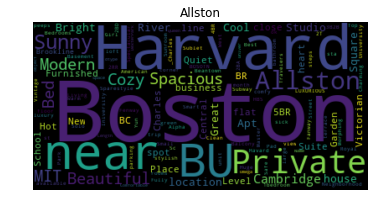

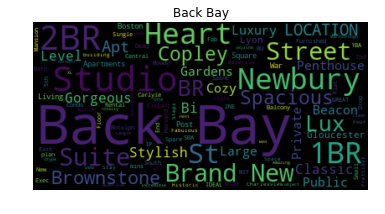

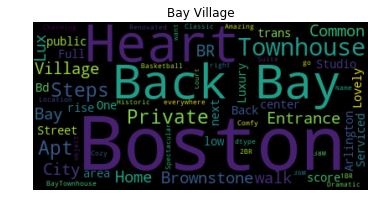

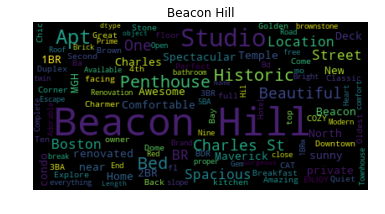

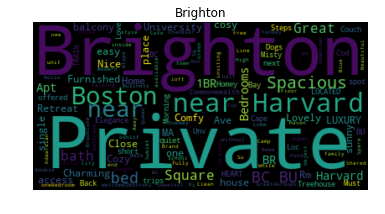

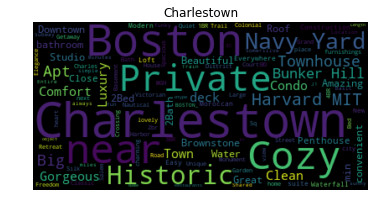

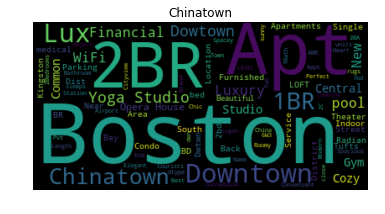

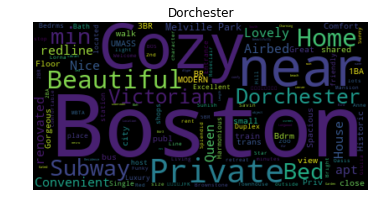

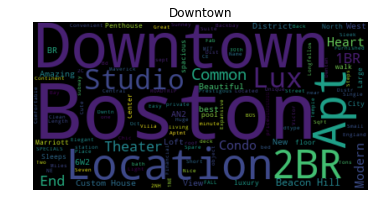

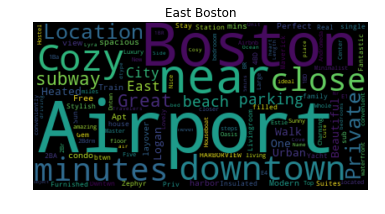

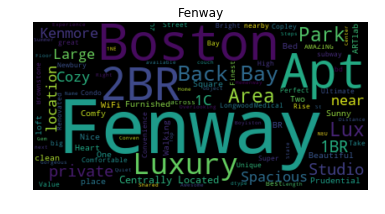

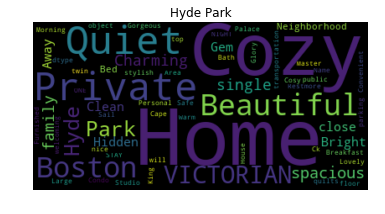

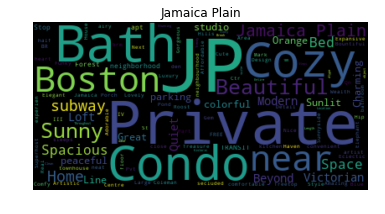

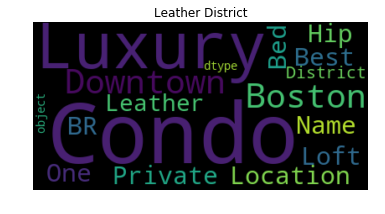

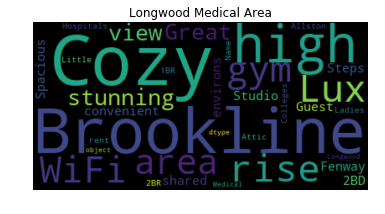

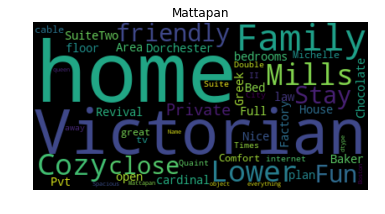

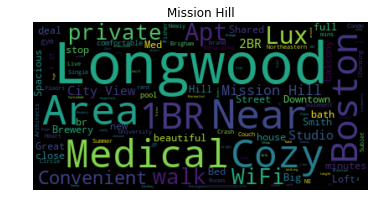

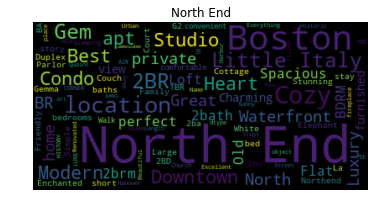

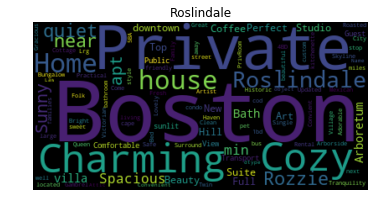

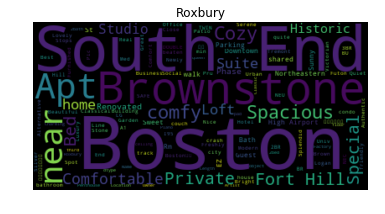

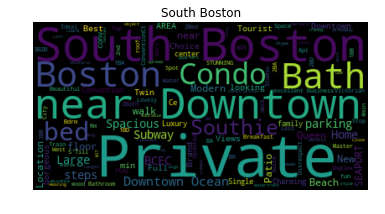

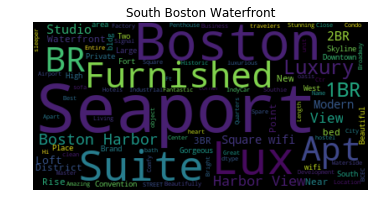

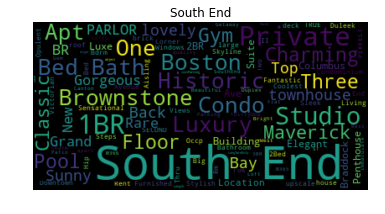

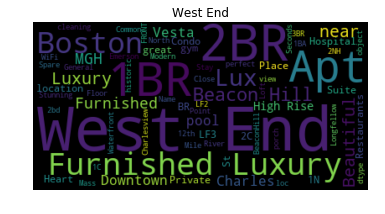

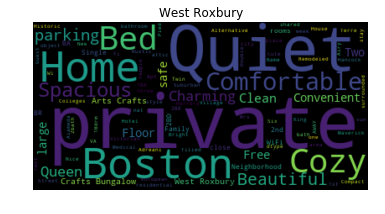

In [63]:
# creating word clouds for the name of the place per neighborhood
name_sum = pd.DataFrame(listings.groupby('neighbourhood_cleansed')['name'].apply(str))

name_sum['neighborhood'] = name_sum.index

name_sum = name_sum.reset_index(drop=True)

sum_stop = set(('apartment', 'room', 'bedroom'))
stop_words = STOPWORDS.union(sum_stop)

word_cloud(name_sum, 'neighborhood', 'name', stop_words)
